## Importar las bibliotecas necesarias y preparar el entorno

In [1]:
!pip install opencv-python-headless numpy

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Crear una carpeta 'img' si no existe para guardar las imágenes resultantes
if not os.path.exists('img'):
    os.makedirs('img')

## Inciso1: Definir función para convertir y reescalar imagen

In [9]:
from skimage import color, transform, io
image_path = './img/person.png'
image = io.imread(image_path)

def convert_and_resize(image, scale):
    # Verificar que el parámetro de escala sea al menos 1
    assert scale >= 1, "El parámetro de escala 'k' debe ser al menos 1."


    # Remover el canal alfa de la imagen (si existe)
    if image.shape[-1] == 4:
        image = image[...,:3]
    
    # Convertir de RGB a escala de grises
    gray_image = color.rgb2gray(image)
    
    # Reescalar la imagen a las dimensiones deseadas (128k x 64k)
    resized_image = transform.resize(gray_image, (128*scale, 64*scale), anti_aliasing=True)
    # 8-bit o float format

    if resized_image.dtype ==np.float64:
        resized_image = resized_image.astype(np.float32)
    else:
        resized_image = (resized_image * 255).astype(np.uint8)

    # Devolver la imagen reescalada
    return resized_image



scale = 50
resized_image = convert_and_resize(image, scale)
resized_image.dtype, resized_image.shape

(dtype('float32'), (6400, 3200))

## Inciso2: Definir función para calcular magnitud y ángulo del gradiente

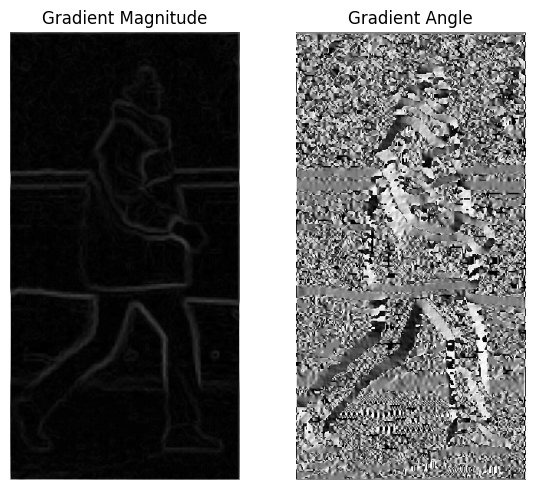

In [11]:
from scipy import ndimage
def gradient_magnitude_and_angle(image):
    # Definir los filtros de Prewitt para Gx y Gy
    Gx_kernel = np.array([[-1, 0, 1],
                   [-1, 0, 1],
                   [-1, 0, 1]])
    
    Gy_kernel = np.array([[-1, -1, -1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])
    
    Gx_conv = ndimage.convolve(image.astype(float), Gx_kernel, mode='constant', cval=0.0)
    Gy_conv = ndimage.convolve(image.astype(float), Gy_kernel, mode='constant', cval=0.0)

    # Calcular la magnitud y ángulo del gradiente
    magnitude = np.sqrt(Gx_conv**2 + Gy_conv**2)
    angle = np.arctan2(Gy_conv, Gx_conv) * (180 / np.pi)

    # normalizar el angulo
    angle[angle < 0] += 180
    angle[angle >= 180] -= 180

    return magnitude, angle


# Load the grayscale image for processing
grayscale_image = io.imread('./img/person.png', as_gray=True)

magnitude, angle = gradient_magnitude_and_angle(grayscale_image)


# Plot the magnitude and angle of the gradient
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 5))

# Display the gradient magnitude
ax1.imshow(magnitude, cmap='gray')
ax1.set_title('Gradient Magnitude')
ax1.axis('off')

# Display the gradient angle
ax2.imshow(angle, cmap='gray')  # HSV color map to better visualize angles
ax2.set_title('Gradient Angle')
ax2.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()



In [17]:
import numpy as np

def build_blocks(magnitude, angle, block_size, stride):

    
    # Calcular las dimensiones de los stacks de bloques basado en las dimensiones de las imágenes y el stride
    M = (magnitude.shape[0] - block_size) // stride + 1
    N = (magnitude.shape[1] - block_size) // stride + 1
    
    
    # Inicializar los stacks de bloques para la magnitud y el ángulo
    blocks_magnitude = np.zeros((M, N, block_size, block_size))
    blocks_angle = np.zeros((M, N, block_size, block_size))
    # Construir los stacks de bloques

    for i in range(M):
        for j in range(N):
            row = i * stride
            col = j * stride
            blocks_magnitude[i, j] = magnitude[row:row+block_size, col:col+block_size]
            blocks_angle[i, j] = angle[row:row+block_size, col:col+block_size]
            
    return blocks_magnitude, blocks_angle


# Construir los stacks de bloques para la magnitud y el ángulo
block_size = 8  # Este valor puede ajustarse
stride = block_size // 2
blocks_magnitude, blocks_angle = build_blocks(magnitude, angle, block_size, stride)


# Imprimir las dimensiones de los stacks de bloques
print(f"Dimensiones de los bloques de magnitud: {blocks_magnitude.shape}")
print(f"Dimensiones de los bloques de ángulo: {blocks_angle.shape}")

Dimensiones de los bloques de magnitud: (145, 74, 8, 8)
Dimensiones de los bloques de ángulo: (145, 74, 8, 8)


In [18]:
# Number of bins as suggested (common choice for HOG features)
n_bins = 9

# Function to calculate the histogram for each block
def calculate_histogram(blocks_magnitude, blocks_angle, n_bins):
    block_shape = blocks_magnitude.shape 
    M, N = block_shape[0], block_shape[1]


    histograms = np.zeros((M, N, n_bins))
    bin_edges = np.linspace(0, 180, n_bins+1)

    for i in range(M):
        for j in range(N):
            block_magnitude = blocks_magnitude[i, j].flatten()
            block_angle = blocks_angle[i, j].flatten()
            
            hist, _ = np.histogram(block_angle, bins=bin_edges, weights=block_magnitude)
            norm = np.linalg.norm(hist)
            histograms[i, j, :] = hist / norm if norm != 0 else hist

    return histograms

# Calculate the histogram for each block
H = calculate_histogram(blocks_magnitude, blocks_angle, n_bins)


# Check the output shape to ensure correctness
H.shape

(145, 74, 9)

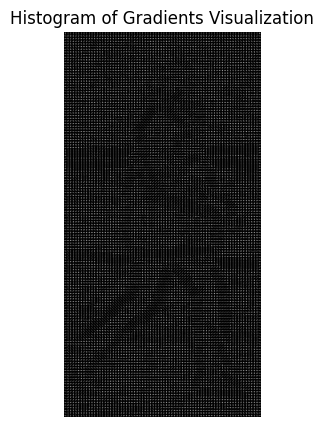

In [22]:

# Function to create a visual representation of the histogram for each block
def histogram_visualization(histograms, block_size, n_bins):
    H_shape = histograms.shape  
    M, N = H_shape[0], H_shape[1]


    visual_image = np.zeros((M*block_size, N*block_size))

    # Degree per bin
    degrees = 180 / n_bins

    for i in range(M):
        for j in range(N):
            block_histogram = histograms[i, j]
            for bin_idx in range(n_bins):
                # Calculate the angle and magnitude for the line
                angle = degrees * (bin_idx + 0.5)  # Angle at the center of the bin
                magnitude = block_histogram[bin_idx] * block_size  # Use magnitude as length of line
                # Calculate the end points of the line
                theta = np.deg2rad(angle)  # Convert angle to radians for np.cos/sin functions
                x_center = j * block_size + block_size // 2
                y_center = i * block_size + block_size // 2
                dx = magnitude * np.cos(theta) / 2
                dy = magnitude * np.sin(theta) / 2
                # Draw the line on the visual image
                cv2.line(visual_image,
                         (int(x_center - dx), int(y_center - dy)),
                         (int(x_center + dx), int(y_center + dy)),
                         color=1,  # White line
                         thickness=1)

    return visual_image



visual_block_size = 16
visual_stride = visual_block_size  # No overlap

# Calculate the histogram visualization for the preprocessed image
H_viz = histogram_visualization(H, visual_block_size, n_bins)

# Plot the visual representation of the histogram
plt.figure(figsize=(10, 5))
plt.imshow(H_viz, cmap='gray')
plt.title('Histogram of Gradients Visualization')
plt.axis('off')
plt.show()


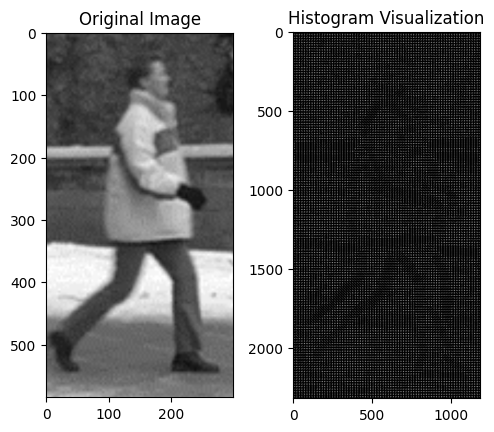

In [23]:
# Assuming `original_image` is your original image after conversion to grayscale and resizing
# and `hist_viz` is the visualization of histograms you created
original_image = image  # Replace this with your original image

# Display the original image and the histogram visualization side by side
plt.figure(figsize=(5, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

# Display the histogram visualization
plt.subplot(1, 2, 2)
plt.imshow(H_viz, cmap='gray')
plt.title('Histogram Visualization')

# Show the plots
plt.tight_layout()
plt.show()
